In [3]:
# Baseline comparison tasks (manual and SVM) 

"""
Visit the project webpage and download the 3 dataset archives. Sample 50 rows from datasetSentences.txt. 
Go through by hand and classify each sentence as Very Positive, Somewhat Positive, Neutral, Somewhat Negative or 
Very Negative (5 class or "fine grained" classification). Compare your results to the ground truth and report 
overall accuracy and precision/recall for each class label. Do the same for the coarse grained task (Positive, Neutral, 
Negative). Create a csv that contains a row for each misclassified example including columns for the text, 
predicted label and true label.
"""

import pandas 

all_sents = pandas.read_table("../sst/datasetSentences.txt", header=None, names=["idx_in_data", "sent"])
all_sents[:3]


,idx_in_data,sent
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic


In [3]:
# Before sampling lets add ground truth labels
# Find the full sent in dictionary.txt to get a lookup key in sentiment_labels.txt

sent_to_key = pandas.read_table("../sst/dictionary.txt", sep="|", header=None, names=["phrase", "senti_key"])
sent_to_key.sample(3)


,phrase,senti_key
57733,"Ultimately , Sarah 's dedication to finding he...",189323
2733,'s finally provided his own broadside at publi...,179750
5630,( for the most part ),23258


In [4]:
senti_labels = pandas.read_table("../sst/sentiment_labels.txt", sep="|", header=None, names=["senti_key", "score"])
senti_labels.sample(3)


,senti_key,score
212067,212067,0.34722
185870,185870,0.16667
9729,9729,0.55556


In [5]:
# Augment table with ground truth and labels; will take a minute
# Note, -LRB- and -RRB- misc characters break lookup; substitutions are inconsistent in dictionary.txt, 
# so skipping for sake of time

senti_scores = []
for sent in all_sents.sent.tolist():
    try: 
        senti_key = sent_to_key[sent_to_key['phrase'] == sent].iloc[0].senti_key
        score = senti_labels[senti_labels['senti_key'] == senti_key].iloc[0].score
        senti_scores.append(score)
    except:         
        senti_scores.append("SKIP")     
    
assert len(senti_scores) == len(all_sents)    

In [6]:

df_final = pandas.DataFrame({"sent": all_sents.sent, "senti_score": senti_scores})
df_final.sample(10) #sanity check

,sent,senti_score
4111,It lets you brush up against the humanity of a...,0.63889
10578,"It never quite makes it to the boiling point ,...",0.61111
378,... a poignant and powerful narrative that rev...,0.70833
3756,Another trumpet blast that there may be a New ...,0.72222
988,A comprehensive and provocative film -- one th...,0.83333
5798,It 's all pretty tame .,0.43056
5883,It 's Tommy 's job to clean the peep booths su...,0.26389
76,"This delicately observed story , deeply felt a...",0.91667
7028,"A particularly joyless , and exceedingly dull ...",0.083333
10639,Screenwriter Dan Schneider and director Shawn ...,0.68056


In [14]:
# add fine and coarse labels

"""
[0, 0.2], (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]
for very negative, negative, neutral, positive, very positive, respectively.

***for coarse, [0, 0.4] (negative) vs. [.6, 1.0] (positive), "SKIP" neutral
"""

senti_map = {"Very Positive": 4, "Somewhat Positive": 3, "Neutral": 2, "Somewhat Negative": 1, 
            "Very Negative": 0, "Positive": 1, "Negative": 0}

fine = []; coarse = []
for score in df_final.senti_score.tolist():
    if 0. <= score <= 0.2:
        fine.append(senti_map["Very Negative"])
        coarse.append(senti_map["Negative"])
    elif 0.2 < score <= 0.4:
        fine.append(senti_map["Somewhat Negative"])
        coarse.append(senti_map["Negative"])
    elif 0.4 < score <= 0.6:
        fine.append(senti_map["Neutral"])
        coarse.append("SKIP")
    elif 0.6 < score <= 0.8:
        fine.append(senti_map["Somewhat Positive"])
        coarse.append(senti_map["Positive"])
    elif 0.8 < score <= 1.0:
        fine.append(senti_map["Very Positive"])
        coarse.append(senti_map["Positive"])   
    else: # if lookup failed from prior step
        fine.append("SKIP")
        coarse.append("SKIP")

assert len(fine) == len(df_final) == len(coarse)

df_final["fine_label"] = fine 
df_final["coarse_label"] = coarse

df_final.sample(10) # sanity check

,sent,senti_score,fine_label,coarse_label
3395,-LRB- Barry -RRB- gives Assassin a disquieting...,SKIP,SKIP,SKIP
9828,Unless Bob Crane is someone of particular inte...,0.33333,1,0
5724,Though the opera itself takes place mostly ind...,0.40278,2,SKIP
10107,"They 're going through the motions , but the z...",0.45833,2,SKIP
5492,Fans of the modern day Hong Kong action film f...,0.72222,3,1
10365,"Wow , a jump cut !",0.41667,2,SKIP
9247,There is simply not enough of interest onscree...,0.25,1,0
11157,"Um , no. .",0.44444,2,SKIP
3321,"While this movie , by necessity , lacks Fellow...",0.66667,3,1
89,While The Isle is both preposterous and thorou...,0.61111,3,1


In [11]:
# Note, percentage of data w/o SKIPs
float(len(df_final[df_final.senti_score != 'SKIP']))/float((len(df_final)))


0.9520033741037537

In [17]:
sample_space = df_final[df_final.senti_score != 'SKIP']
samples = sample_space.sample(50)
sample_sents = samples.sent.tolist()
sample_sents

["If you like peace , you 'll like Promises .",
 "Even at its worst , it 's not half-bad .",
 'A movie that falls victim to frazzled wackiness and frayed satire .',
 'is an inexpressible and drab wannabe looking for that exact niche .',
 'An unsuccessful attempt at a movie of ideas .',
 'A well-executed spy-thriller .',
 "Provides the kind of ` laugh therapy ' I need from movie comedies -- offbeat humor , amusing characters , and a happy ending .",
 "It 's a Count for our times .",
 'Manages to be sweet and wickedly satisfying at the same time .',
 'An intimate contemplation of two marvelously messy lives .',
 "Pair that with really poor comedic writing ... and you 've got a huge mess .",
 'Starts promisingly but disintegrates into a dreary , humorless soap opera .',
 "Nonsensical , dull `` cyber-horror '' flick is a grim , hollow exercise in flat scares and bad acting .",
 "For all its technical virtuosity , the film is so mired in juvenile and near-xenophobic pedagogy that it 's enou

In [36]:
# guessing manually then adding to make new sample_df
# see above senti_map... 0-4 for fine task, 0-1 for coarse

fine_guess = [3, 3, 1, 1, 1, 3, 3, 3, 3, 2, 0, 1, 0, 1, 1, 3, 3, 4, 2, 0, 4, 2, 3, 3, 2, 1, 2, 0, 0, 1, 0, 
              4, 2, 4, 3, 0, 1, 3, 2, 3, 1, 4, 4, 2, 3, 1, 0, 2, 1, 4]

coarse_guess = [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 
                1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]

samples_df = pandas.DataFrame({ "sample_sents": samples.sent, "fine_guess":  fine_guess, "coarse_guess": coarse_guess, 
                              "fine_gt": samples.fine_label, "coarse_gt": samples.coarse_label })

In [37]:
samples_df[:10]

,coarse_gt,coarse_guess,fine_gt,fine_guess,sample_sents
3277,1,1,3,3,"If you like peace , you 'll like Promises ."
2961,1,1,3,3,"Even at its worst , it 's not half-bad ."
11185,SKIP,0,2,1,A movie that falls victim to frazzled wackines...
10186,0,0,1,1,is an inexpressible and drab wannabe looking f...
6793,0,0,1,1,An unsuccessful attempt at a movie of ideas .
11708,1,1,4,3,A well-executed spy-thriller .
2887,1,1,4,3,Provides the kind of ` laugh therapy ' I need ...
561,SKIP,1,2,3,It 's a Count for our times .
1310,1,1,4,3,Manages to be sweet and wickedly satisfying at...
5165,1,1,3,2,An intimate contemplation of two marvelously m...


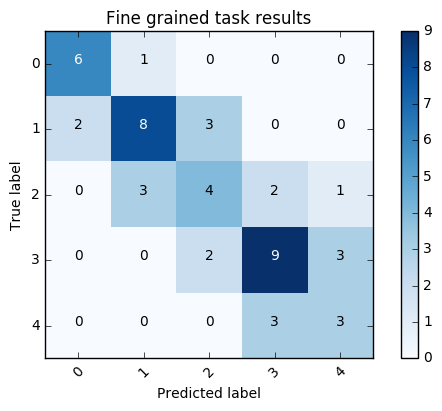

In [102]:
# confusion matrix 

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
samples_df.fine_gt = samples_df.fine_gt.astype(int)
samples_df.fine_guess = samples_df.fine_guess.astype(int)

truth = samples_df.fine_gt
pred = samples_df.fine_guess

cnf_matrix = confusion_matrix(truth, pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4], title='Fine grained task results')    
plt.show()



In [119]:
# Fine grained task stats:

# Manually for first class (0 - very negative)

# Accuracy 
# (TP + TN) / all
# (6 + 41)/ 50 = 94% 

# Precision 
# TP/(TP + FP)
# 6 / (6 + 2) = 75%

# Recall
# TP/(TP + FN)
# 6/ (6 + 1) = 86% 


# The rest

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(truth, pred, digits=4))

print("With overall accuracy: {:.4f}".format(accuracy_score(truth, pred)))



             precision    recall  f1-score   support

          0     0.7500    0.8571    0.8000         7
          1     0.6667    0.6154    0.6400        13
          2     0.4444    0.4000    0.4211        10
          3     0.6429    0.6429    0.6429        14
          4     0.4286    0.5000    0.4615         6

avg / total     0.5987    0.6000    0.5980        50

With overall accuracy: 0.6000


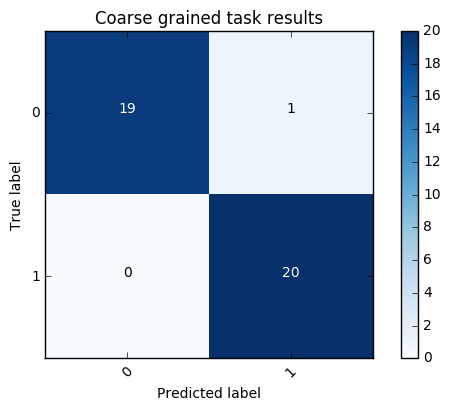

In [124]:
# Coarse grained evaluation 
# Total count will be reduced because removing "2" neutral sentiment from 50 originals;
# I could re-sample for non "2" for this task

samples_df2 = samples_df[samples_df.coarse_gt != "SKIP"]
samples_df2.coarse_gt = samples_df2.coarse_gt.astype(int)
samples_df2.coarse_guess = samples_df2.coarse_guess.astype(int)

truth = samples_df2.coarse_gt
pred = samples_df2.coarse_guess

cnf_matrix = confusion_matrix(truth, pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Coarse grained task results')    
plt.show()




In [125]:
print(classification_report(truth, pred, digits=4))

print("With overall accuracy: {:.4f}".format(accuracy_score(truth, pred)))



             precision    recall  f1-score   support

          0     1.0000    0.9500    0.9744        20
          1     0.9524    1.0000    0.9756        20

avg / total     0.9762    0.9750    0.9750        40

With overall accuracy: 0.9750


In [233]:
# Finally, save CSVs with misclassifications 

misclf_fine_df = samples_df[samples_df.fine_guess != samples_df.fine_gt]
misclf_coarse_df = samples_df2[samples_df2.coarse_guess != samples_df2.coarse_gt]
print("Num misclass fine: \n {}".format(len(misclf_fine_df)))
print("Num misclass coarse: \n {}".format(len(misclf_coarse_df)))

misclf_fine_df = misclf_fine_df.filter(['fine_gt', 'fine_guess', 'sample_sents'], axis=1)
misclf_coarse_df = misclf_coarse_df.filter(['coarse_gt', 'coarse_guess', 'sample_sents'], axis=1)

misclf_fine_df.to_csv("misclf_manual_fine.csv")
misclf_coarse_df.to_csv("misclf_manual_coarse.csv")



Num misclass fine: 
 20
Num misclass coarse: 
 1


In [271]:
# SVM BASELINE 

"""
Use spacy and sklearn to create an SVM classifier that uses pretrained word vectors (GloVe) 
and bag of words features. Average the vectors for each token in the sentence (minus stop words) 
to create a sentence vector. Use the fiixed size sentence vector as the feature input for your classifier. 
Do some minimal hyperparameter tuning using GridSearchCV. Report accuracy plus precision/recall for each class 
label for both the coarse grained and fine grained classification tasks. Create a csv that contains a row for each 
misclassified example including columns for the text, predicted label and true label.
"""

import spacy 
nlp = spacy.load('en')

# switch 50d 
vecs = open("../assets/glove.6B.50d.txt")
nlp.vocab.load_vectors(vecs)
doc = nlp(u"hello there")
assert len(doc[0].vector) == 50


In [272]:
# Add col for sent vector

import numpy as np

sent_vecs = []
for sent in df_final.sent.tolist():
    word_vecs = [x.vector for x in nlp(unicode(sent, errors='ignore')) if not x.is_stop]
    sent_vec = np.average(word_vecs, axis=0)
    sent_vecs.append(sent_vec)
    
assert len(sent_vecs) == len(df_final)
assert np.shape(sent_vecs)[1] == 50


In [275]:
df_final["sent_vec"] = sent_vecs
df_final.sample(3)



,sent,senti_score,fine_label,coarse_label,sent_vec
1919,"For his first attempt at film noir , Spielberg...",0.63889,3,1,"[0.393769, 0.128051, -0.247352, -0.0943897, 0...."
5699,Such master screenwriting comes courtesy of Jo...,0.83333,4,1,"[-0.0443398, 0.260765, -0.0835923, -0.173025, ..."
10247,"Director Elie Chouraqui , who co-wrote the scr...",0.23611,1,0,"[0.0209001, -0.0141412, -0.134606, -0.217842, ..."


In [298]:
# train - test; dev - train for GridSearchCV
# get splits from datasetSplit.txt... or arbitrary

df_train = df_final[:-1200]
df_test = df_final[-1200:]

In [299]:
# Fine grained SVM

from sklearn import svm
from sklearn.grid_search import GridSearchCV
svm_c = svm.SVC()

df_train2 = df_train[df_final.fine_label != "SKIP"]
features = df_train2.sent_vec.tolist()
labels = df_train2.fine_label.tolist()

gamma = 10.**np.arange(-3, 0)
C = 10.**np.arange(-1, 2)
kernels = ['rbf']#, 'sigmoid','poly']
hyperps = {'gamma': gamma, 'C': C, 'kernel': kernels }

gs = GridSearchCV(svm_c, hyperps, cv=5, scoring='accuracy')
gs.fit(features, labels)


/Users/richard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': array([  0.1,   1. ,  10. ]), 'gamma': array([ 0.001,  0.01 ,  0.1  ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [301]:
print("Best fine train accuracy --> {:.4f} \n".format(gs.best_score_))
print(gs.best_params_)
print(gs.best_estimator_)

Best fine train accuracy --> 0.3785 

{'kernel': 'rbf', 'C': 10.0, 'gamma': 0.10000000000000001}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [303]:
# Fine grained SVM precision/ recall etc.

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

df_test_fine = df_test[df_test.fine_label != "SKIP"]
features = df_test_fine.sent_vec.tolist()
y_fine = df_test_fine.fine_label.tolist()

pred_fine = gs.predict(features)
print("With fine test accuracy: {}\n".format(accuracy_score(y_fine, pred_fine)))
print(classification_report(y_fine, pred_fine, digits=4))


With fine test accuracy: 0.360988526037

             precision    recall  f1-score   support

          0     0.5106    0.0930    0.1574       258
          1     0.4703    0.6064    0.5297       470
          2     0.2804    0.1282    0.1760       234
          3     0.1698    0.4615    0.2483       117
          4     0.2909    0.2963    0.2936        54

avg / total     0.4007    0.3610    0.3316      1133



In [304]:
# Coarse grained SVM

from sklearn import svm
svm_c = svm.SVC()

df_train2 = df_train[df_final.coarse_label != "SKIP"]
features = df_train2.sent_vec.tolist()
labels = df_train2.coarse_label.tolist()

gamma = 10.**np.arange(-3, 0)
C = 10.**np.arange(-1, 2)
kernels = ['rbf']#, 'sigmoid','poly']
hyperps = {'gamma': gamma, 'C': C, 'kernel': kernels }

gs = GridSearchCV(svm_c, hyperps, cv=5, scoring='accuracy')
gs.fit(features, labels)


/Users/richard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf'], 'C': array([  0.1,   1. ,  10. ]), 'gamma': array([ 0.001,  0.01 ,  0.1  ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [305]:
print("Best train coarse accuracy --> {:.4f} \n".format(gs.best_score_))
print(gs.best_params_)
print(gs.best_estimator_)

Best train coarse accuracy --> 0.7274 

{'kernel': 'rbf', 'C': 10.0, 'gamma': 0.10000000000000001}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [308]:
# Coarse grained SVM precision/ recall

df_test_coarse = df_test[df_test.coarse_label != "SKIP"]
features = df_test_coarse.sent_vec.tolist()
y_coarse = df_test_coarse.coarse_label.tolist()

pred_coarse = gs.predict(features)
print("With coarse test accuracy: {}\n".format(accuracy_score(y_coarse, pred_coarse)))
print(classification_report(y_coarse, pred_coarse, digits=4))


With coarse test accuracy: 0.725250278087

             precision    recall  f1-score   support

          0     0.9125    0.7308    0.8116       728
          1     0.3797    0.7018    0.4928       171

avg / total     0.8112    0.7253    0.7510       899



In [310]:
# misclassifications csv

df_test_fine["prediction"] = pred_fine
df_test_coarse["prediction"] = pred_coarse

misclf_fine_df = df_test_fine[df_test_fine.fine_label != df_test_fine.prediction]
misclf_coarse_df = df_test_coarse[df_test_coarse.coarse_label != df_test_coarse.prediction]
print("Num misclass SVM fine: \n {}".format(len(misclf_fine_df)))
print("Num misclass SVM coarse: \n {}".format(len(misclf_coarse_df)))

misclf_fine_df = misclf_fine_df.filter(['fine_label', 'prediction', 'sent'], axis=1)
misclf_coarse_df = misclf_coarse_df.filter(['coarse_label', 'prediction', 'sent'], axis=1)

misclf_fine_df.to_csv("misclf_svm_fine.csv")
misclf_coarse_df.to_csv("misclf_svm_coarse.csv")



Num misclass SVM fine: 
 724
Num misclass SVM coarse: 
 247


/Users/richard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/richard/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [151]:
# RNTN results 



# classifier results on test set 
rntn = pandas.read_csv("rntn_predictions_raw.csv")
rntn.sample(3)


,test_id,logit_raw_root,y_onehot_root,fine_guess,fine_label,all_node_acc
548,548,[-1.64839733 -0.54215133 -0.03517973 -0.591024...,"[0.0, 0.0, 0.0, 0.0, 1.0]",2,4,0.727273
519,519,[-1.67191339 -0.54016113 -0.09440076 -0.601565...,"[1.0, 0.0, 0.0, 0.0, 0.0]",2,0,0.776471
936,936,[-1.6897788 -0.54175001 -0.33596492 -0.218336...,"[0.0, 0.0, 0.0, 0.0, 1.0]",3,4,0.686275


In [154]:
print("Root label accuracy {:.6f}\n".format(accuracy_score(rntn.fine_label, rntn.fine_guess)))
print("All node accuracy {:6f}\n".format(np.mean(rntn.all_node_acc)))
print(classification_report(rntn.fine_label, rntn.fine_guess, digits=4))



Root label accuracy 0.205430

All node accuracy 0.729853

             precision    recall  f1-score   support

          0     0.1429    0.0072    0.0137       279
          1     0.3700    0.0585    0.1010       633
          2     0.1828    0.7326    0.2926       389
          3     0.2430    0.2549    0.2488       510
          4     0.0000    0.0000    0.0000       399

avg / total     0.2123    0.2054    0.1396      2210



In [155]:
rntn.fine_guess.value_counts()  # clearly skewed to neutral, due to all_node training labels being mostly neutral



2    1559
3     535
1     100
0      14
4       2
Name: fine_guess, dtype: int64

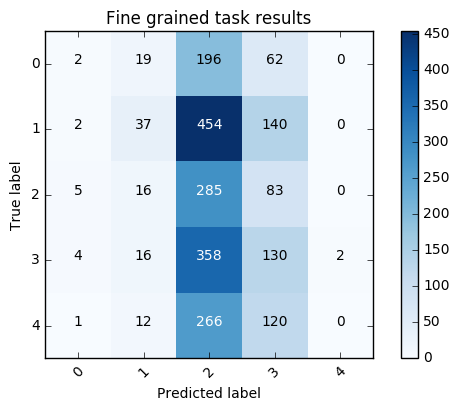

In [156]:
      
cnf_matrix = confusion_matrix(rntn.fine_label, rntn.fine_guess)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1,2,3,4], title='Fine grained task results')    
plt.show()
    

In [ ]:
# Note, for comparison sake only comparing on root label; 
# could in theory break up SVM task inputs into phrases and score on all 
# all node accuracy is significantly better than root accuracy 

# TODO Coarse comparison
# retrain from scratch with root labels (only) in coarse form, removing trees with root neutral labels; 
# NOTE can't discard neutral labels in non root nodes (all have them), so can't do a coarse all node task 



In [157]:
# Add sent text, save misclassified 

# to get sent text dataSplits.txt --> dataSentences.txt --> test_ids (indexes)
# 1-train 2-test 3-dev

splits = pandas.read_csv("../sst/datasetSplit.txt")
test_is = splits[splits.splitset_label == 2].sentence_index.tolist() 


sents_df = pandas.read_table("../sst/datasetSentences.txt", header=None, names=["idx", "sent"])
sents_df

sents = sents_df[sents_df.idx.isin(test_is)].sent.values.tolist()
rntn['sent_text'] = sents
rntn.sample(3)



,test_id,logit_raw_root,y_onehot_root,fine_guess,fine_label,all_node_acc,sent_text
1532,1532,[-1.71784401 -0.52453256 0.20746827 -0.782469...,"[0.0, 1.0, 0.0, 0.0, 0.0]",2,1,0.878788,Borrows from so many literary and cinematic so...
970,970,[-1.65271211 -0.4595637 0.1523335 -0.806114...,"[0.0, 0.0, 0.0, 1.0, 0.0]",2,3,0.711111,"A perverse little truffle , dainty psychologic..."
1431,1431,[-1.82306993 -0.53300166 0.24900055 -0.379499...,"[1.0, 0.0, 0.0, 0.0, 0.0]",2,0,0.578947,Julia is played with exasperating blandness by...


In [159]:

misses_rntn = rntn.filter(['fine_label', 'fine_guess', 'sent_text'], axis=1)[rntn.fine_guess != rntn.fine_label]


print("writing {:d}/ {:d} misclassified for root label, fine grained task". \
      format(len(misses_rntn), len(rntn)))

misses_rntn.to_csv("misclf_rntn_fine.csv")



writing 1756/ 2210 misclassified for root label, fine grained task
